# Monatliche Auswertung der Sensordaten auf Raumebene
____
In diesem Notebook befinden sich monatliche Auswertungen der Sensoren. 


## Allgemeines

Hinweis:
Datenbank update wird automatisch ausgeführt, wenn neuere Daten verfügbar sind. Dies kann einige Zeit in Anspruch nehmen. Wenn das Update unterdrückt werden soll im folgenden Block 'update_databases' auskommentieren.

In [45]:
import datetime as dt
import os
import re

import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages

from src import update_databases
plt.style.use('./src/stylesheets/eb3.mplstyle')
from src.utilities import set_ticks, recolor_lines, truncate_colormap, calcTOP, KOMPASS, din_a4, eb_bbox
from src.project_definitions import WANDFLÄCHEN, TIR, KORREKTUR_RH, BUID, WOHNUNGEN, ROOMS, dir_results
from src.graphs import comfort_hx_diagramm, thermal_comfort_1, thermal_comfort_2

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

##### READ Data #####
startdate = '2021-06-01'

print('Starte Import der Datensätze - das kann etwas dauern...')
from src.sensor_reader import IND, AMB
print('...Import beendet')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starte Import der Datensätze - das kann etwas dauern...
...Import beendet


## Vergleich der pro Raum
___

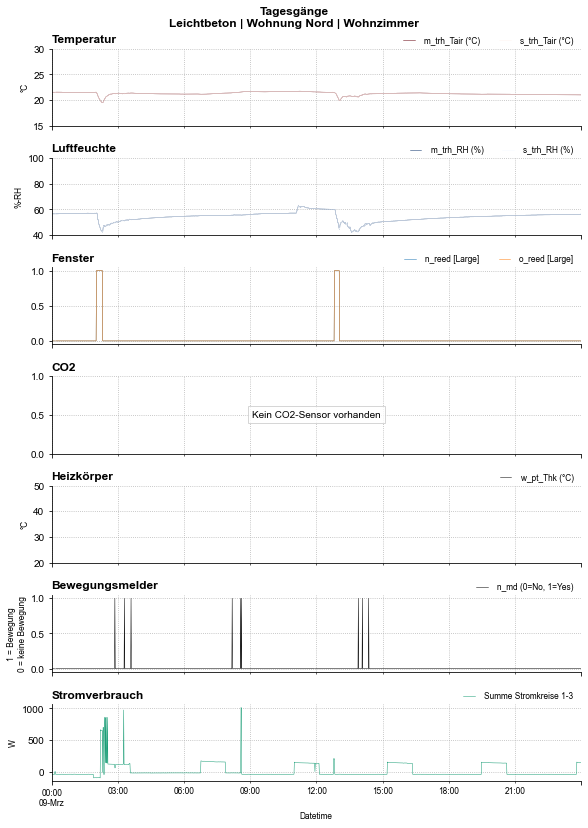

In [2]:
bui = 'LB'

app = 'N'       # 'N' = Nord, 'S' = Süd, 'O' = Ost

room = 'WZ'     # 'WZ', 'SZ', 'F', 'K': Nord, Süd; 'B': Alle; 'SWK': nur Ost

date = '2022-03-09'

fig, axs = plt.subplots(7,1, figsize=din_a4, sharex=True)

plt.style.use('./src/stylesheets/DailyApp.mplstyle')

fig.suptitle(f'Tagesgänge\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}', fontweight = 'bold')

ax = axs[0]
ax.set_title('Temperatur')
IND[bui][app][room].loc[date].filter(like='_trh_Tair').plot(ax=ax,cmap='Reds_r')
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(15, 30)
ax.set_ylabel('°C')

ax = axs[1]
ax.set_title('Luftfeuchte')
(IND[bui][app][room].loc[date].filter(like='_trh_RH')-KORREKTUR_RH[bui]).plot(ax=ax,cmap='Blues_r',label = ['Raumluftfeuchte'])
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(40, 100)
ax.set_ylabel('%-RH')

ax = axs[2]
ax.set_title('Fenster')
#----#6: Windows ----
try:
    windows = IND[bui][app][room].loc[date].filter(like='reed').replace(['Closed','Open'],[0,1]).plot(ax=ax)
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
except Exception as e:
    ax.text(0.5,0.5,'Kein Fenster vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=eb_bbox, 
                )
    print(e)

ax = axs[3]
ax.set_title('CO2')
try:
    IND[bui][app][room].loc[date].filter(like='_co2 ').plot(ax=ax,cmap='Greens_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylim(0,3000)
    ax.set_ylabel('ppm')
except:
    ax.text(0.5,0.5,'Kein CO2-Sensor vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=eb_bbox, 
                )
    pass

ax = axs[4]
ax.set_title('Heizkörper')
try:
    IND[bui][app][room].loc[date].filter(like='pt_Thk ').plot(ax=ax,cmap='Greys_r', label = 'Oberflächentemperatur')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    if bui in ['LB', 'MH']:
        ax.set_ylim(20, 50)
    if bui == 'MW':
        ax.set_ylim(20, 70)
    ax.set_ylabel('°C')
except:
    ax.text(0.5,0.5,'Keine Heizkörpertemperatur vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=eb_bbox, 
                )
    pass

ax = axs[5]
ax.set_title('Bewegungsmelder')
try:
    IND[bui][app][room].loc[date].filter(like='_md ').plot(ax=ax,cmap='Greys_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylabel('1 = Bewegung\n0 = keine Bewegung')
except:
    ax.text(0.5,0.5,'Kein Bewegungsmelder vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=eb_bbox, 
                )
    pass

ax = axs[6]
IND[bui][app][''].loc[date].filter(like='(W)').sum(axis=1).plot(ax=ax,cmap='Dark2', label = 'Summe Stromkreise 1-3') #.sum(axis=1)
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_title('Stromverbrauch')
#ax.set_ylim(0, 2500)
ax.set_ylabel('W')
fig.tight_layout()

## Allgemeines
___

#### Sollen ALLE Graphen geupdatet werden?
Wenn ``ex = True``  werden alle Graphen neu erstellt. Dies kann sehr viel Zeit in Anspruch nehmen. Setze ``ex = False``, um nur einzelne Graphen/Monate zu erstellen.

Wenn nur einzelne Graphen erstellt/aktualisiert werden sollen, kann im zweiten Block ausgewählt werden, welcher Monat geplottet werden soll.

In [3]:
##### USER INPUTS #####
ex = False

if ex:
    _BUID = BUID
    _wohnungen = WOHNUNGEN   
else:
    # Bauweise 
    _BUID = ['MH']
    # Wohnung
    _wohnungen = ['O']
    # Monat
    focus = '7 2021'
    
    month, year = focus.split()
    focus_month = dt.date(int(year),int(month),1)

_rooms = ROOMS

## **Monatliche Auswertung auf Raumebene**
____

Done!                                                                                                                                                                          


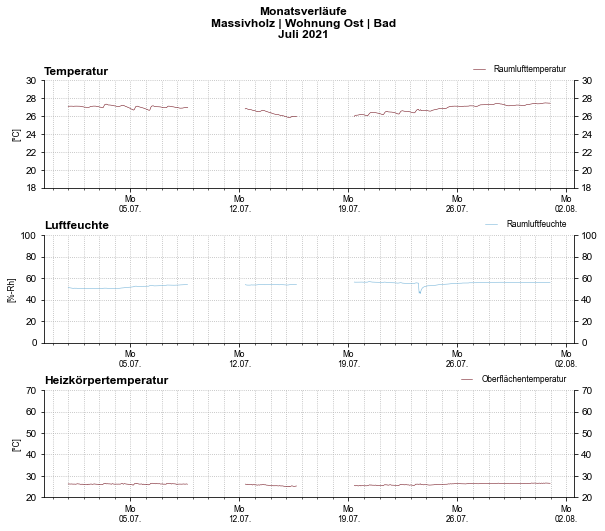

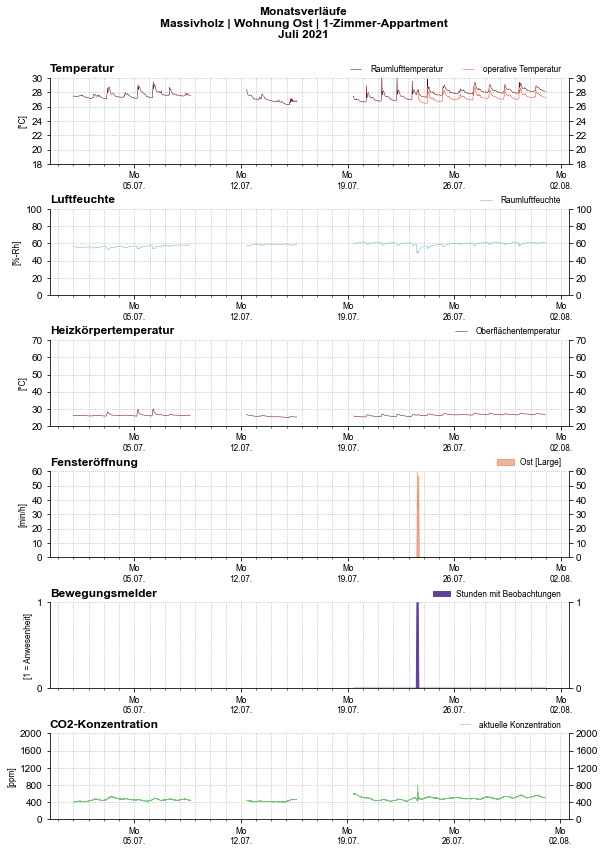

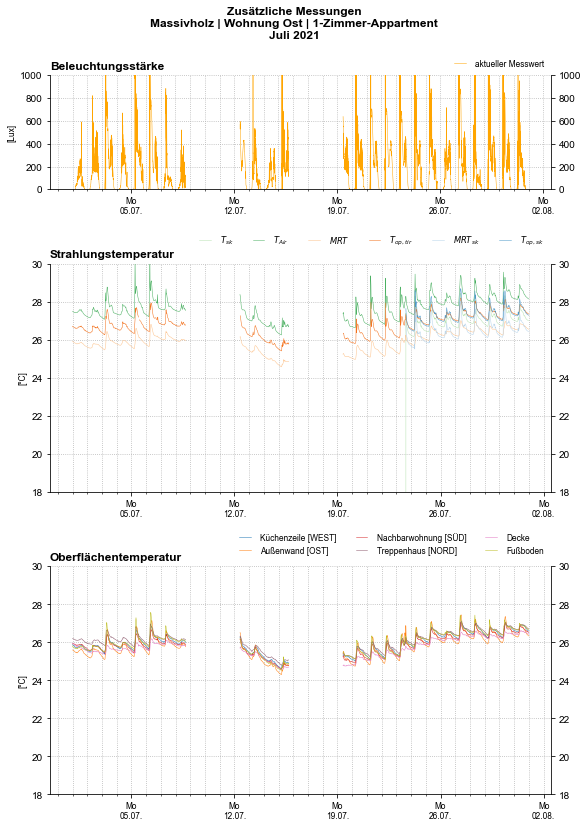

In [6]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    for date, ind in IND[bui].groupby(by=[IND[bui].index.month, IND[bui].index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        else:
            amb = AMB[AMB.index.month == date.month]
            for a, app in enumerate(_wohnungen):
                path = os.path.join(dir_results,'Monatliche Übersicht',BUID[bui],WOHNUNGEN[app])
                if not os.path.exists(path): os.makedirs(path)
                try:
                    with PdfPages(os.path.join(path,f'{bui}_{app}_Raumklima_{date:%y%m}.pdf')) as pdf:
                        for room in _rooms:
                            if room in ind[app].columns.get_level_values(level=0).unique():
                                if not ex:
                                        print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%B %Y")} ---'+100*' ', flush=True, end='\r')
                                #define figure
                                fig = plt.figure(figsize=din_a4, constrained_layout=True)
                                gs = GridSpec(6, 1, figure=fig)
                                axs=[]
                                i=0
                                fig.suptitle(f'Monatsverläufe\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                #----#1: Temperature ----
                                sensor = 'trh_Tair'
                                df = ind[app][room].filter(like=sensor)
                                if len(df.columns) > 0:
                                    if len(df.columns) > 1:
                                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                        df.drop(df.columns[1],axis=1,inplace=True)
                                    axs.append(fig.add_subplot(gs[i,:]))
                                    Tair = df
                                    axs[i].plot(Tair.resample('30min').last(),label = 'Raumlufttemperatur')
                                    axs[i].set_ylim(15,30)

                                    sensor = 'pt_Tsk'
                                    df = ind[app][room].filter(like=sensor)
                                    if len(df.columns) > 0:
                                        Tsk = df
                                        Top = calcTOP(Tair,Tsk)
                                        axs[i].plot(Top.resample('30min').last(), label = 'operative Temperatur')
                                    
                                    recolor_lines(axs[i], 'Reds_r', 0 ,0.8)

                                    axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[°C]')
                                    set_ticks(axs[i],18,30,2)
                                    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1
                                #----#2: Humidity ----
                                sensor = 'trh_RH'
                                df = ind[app][room].filter(like=sensor)
                                if len(df.columns) > 0:
                                    if len(df.columns) > 1:
                                        df.iloc[:,0].fillna(df.iloc[:,1],inplace=True)
                                        df.drop(df.columns[1],axis=1,inplace=True)
                                    df.columns = ['Rh']
                                    Rh = df.replace([' ',''], np.NAN)
                                    ## Korrektur Messwert:
                                    Rh = Rh - KORREKTUR_RH[bui]
                                    axs.append(fig.add_subplot(gs[i, :]))
                                    axs[i].plot(Rh.resample('H').last(),label = 'Raumluftfeuchte')
                                    recolor_lines(axs[i], 'Blues', minint=0.5,maxint=1)

                                    axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[%-Rh]')

                                    set_ticks(axs[i],0,100,20)
                                    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1

                                #----#3: Heizkörpertemperatur ----
                                sensor = 'pt_Thk'
                                df = ind[app][room].filter(like=sensor)
                                if len(df.columns) > 0:
                                    axs.append(fig.add_subplot(gs[i,:]))
                                    axs[i].plot(df.resample('H').last(),label = 'Oberflächentemperatur')
                                    recolor_lines(axs[i], 'Reds_r', 0,0.8)
                                    axs[i].set_title('Heizkörpertemperatur', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[°C]')
                                    set_ticks(axs[i], 20, 70, 10)
                                    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1
                                else:
                                    pass

                                #----#6: Windows ----
                                windows = ind[app][room].filter(like='reed')
                                c = [mpl.cm.Oranges(0.75),mpl.cm.Greens(0.75)]
                                if len(windows.columns) > 0:
                                    axs.append(fig.add_subplot(gs[i, :]))
                                    windows.replace(['Closed','Open'],[0,1],inplace=True)
                                    windows = windows.resample('H').sum()
                                    labels, patches = [], []
                                    for w,col in enumerate(windows.columns):
                                        axs[i].fill_between(x=windows.index, y1=windows[col], color=c[w], alpha=0.4)
                                        #axs[i].plot(windows[col], color=c[w])
                                        patches.append(mpl.patches.Patch(color=c[w], alpha=0.4))
                                        ori = KOMPASS[col.split('_')[0]]
                                        size = re.search(r'\[(.*?)\]', col)[0]
                                        labels.append(f'{ori} {size}')
                                    axs[i].legend(handles=patches, labels=labels,loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    axs[i].set_title('Fensteröffnung', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[min/h]')
                                    set_ticks(axs[i], 0, 60, 10)
                                    axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1
                                else:
                                    pass
                                #----#4: Bewegungsmelder ----
                                sensor = '_md'
                                df = ind[app][room].filter(like=sensor)
                                if len(df.columns) > 0:
                                    df.columns = ['md']

                                    axs.append(fig.add_subplot(gs[i,:]))
                                    df = df.resample('H').max()
                                    for c, col in enumerate(df.columns):
                                        axs[i].fill_between(df.index, df[col], color=mpl.cm.Purples(0.8), label='Stunden mit Beobachtungen')
                                    #recolor_lines(axs[i], 'Purples_r' ,minint=0 ,maxint=0.8)
                                    set_ticks(axs[i],0,1,1)
                                    #axs[i].set_ylim(0,60)
                                    axs[i].set_title('Bewegungsmelder', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[1 = Anwesenheit]')
                                    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    #axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1
                                else:
                                    pass

                                #----#5: CO2 ----
                                sensor = 'co2'
                                if len(ind[app][room].filter(like=sensor).columns) == 0:
                                    pass
                                else: 
                                    sensors = list(ind[app][room].filter(like=sensor).columns)
                                    for sensor in sensors:
                                        if sensor.count('_') == 1:
                                            sensors = sensor

                                    axs.append(fig.add_subplot(gs[i, :]))
                                    axs[i].plot(ind[app][room][sensors],label = 'aktuelle Konzentration')

                                    recolor_lines(axs[i], 'Greens', 0.5, 1)

                                    axs[i].set_title('CO2-Konzentration', fontweight = 'bold',loc='left')
                                    axs[i].set_ylabel('[ppm]')
                                    set_ticks(axs[i],0,2000,400)
                                    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
                                    axs[i].grid(axis="y", ls='dotted')
                                    axs[i].grid(axis='x',which='both', linestyle='dotted')
                                    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    axs[i].spines['right'].set_visible(True)
                                    i+=1

                                for ax in axs:
                                    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m.'))
                                    ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
                                    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

                                pdf.savefig(fig)
                                if ex: plt.clf()

                                if app == 'O' and room == 'SWK':
                                    rauschen = '30min'

                                    group = ind[app][room]

                                    month = date.strftime('%B %Y')

                                    fig, axs = plt.subplots(3,1, figsize=din_a4, gridspec_kw={'height_ratios': [1, 2, 2]})
                                    fig.suptitle(f'Zusätzliche Messungen\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                                                        
                                    # Ambient Light
                                    sensorname = 'm_al (lux)'
                                    ax = axs[0]
                                    df = group[sensorname]
                                    ax.plot(df, label = 'aktueller Messwert', color='orange')
                                    #ax.plot(df.resample('H').mean(), label = 'stündlicher Mittelwert', linestyle='dashed', color='k')

                                    ax.set_title(f'Beleuchtungsstärke')
                                    ax.set_ylabel('[Lux]')
                                    set_ticks(ax, min=0, max=1000)
                                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False, markerscale=4)
                                    ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    ax.spines['right'].set_visible(True)

                                    # Strahlungstemperaturen
                                    ax = axs[1]

                                    ## Tsk
                                    sensorname = 'm_pt_Tsk (°C)'
                                    Tsk = group[sensorname].resample(rauschen).mean()
                                    ax.plot(Tsk, label = r'$T_{sk}$',c=plt.cm.Greens(0.3))

                                    ## Tair
                                    sensorname = 'm_trh_Tair (°C)'
                                    Tair = group[sensorname].resample(rauschen).mean()
                                    ax.plot(Tair, label = r'$T_{Air}$',c=plt.cm.Greens(0.6))

                                    ## MRT
                                    MRT = 0
                                    for key, item in TIR[bui].items():
                                        MRT += group[key] * WANDFLÄCHEN[item]
                                    MRT /= sum(WANDFLÄCHEN.values())
                                    MRT = MRT.resample(rauschen).mean()
                                    ax.plot(MRT, label = r'$MRT$',c=plt.cm.Oranges(0.3))

                                    ## Top,air
                                    sensorname = 'm_trh_Tair (°C)'
                                    Top_air = ((group[sensorname]+MRT)/2).resample(rauschen).mean()
                                    ax.plot(Top_air, label = r'$T_{op, tir}$',c=plt.cm.Oranges(0.6))

                                    ## MRT,sk
                                    E = 0.94    # [-] Quelle https://www.flir-infrarotkameras.de/FLIR-Technik-und-Funktionen/Emissionsgrad-Tabelle    
                                    D = 0.07    # [m]
                                    MRT_sk = (( ( (Tsk + 273)**4 ) + ( (0.25*10**8) / E ) * ( abs(Tsk - Tair) / D )**(1/4) * (Tsk - Tair) )**(1/4) - 273).resample(rauschen).mean()
                                    ax.plot(MRT_sk, label = r'$MRT_{sk}$',c=plt.cm.Blues(0.3))

                                    ## Top,sk
                                    Top_sk = ((MRT_sk + Tair) / 2).resample(rauschen).mean()
                                    ax.plot(Top_sk, label = r'$T_{op,sk}$',c=plt.cm.Blues(0.6))


                                    ax.set_title(f'Strahlungstemperatur')
                                    ax.set_ylabel('[°C]')
                                    set_ticks(ax, min=18, max=30)
                                    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False, markerscale=4)
                                    ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    ax.spines['right'].set_visible(True)

                                    # Oberflächentemperaturen
                                    ax = axs[2]
                                    for i, sensorname in enumerate(TIR[bui]):
                                        ax.plot(group[sensorname].resample(rauschen).mean(), label = f'{TIR[bui][sensorname]}',linewidth=.5) 
                                    recolor_lines(ax, 'tab10')
                                    ax.set_title(f'Oberflächentemperatur')
                                    ax.set_ylabel('[°C]')
                                    set_ticks(ax, min=18, max=30,step=2)
                                    #ax.legend(markerscale=2)
                                    ax.legend(loc='center right',ncol=3,bbox_to_anchor=(1,1.1),frameon=False, markerscale=4)
                                    ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
                                    ax.spines['right'].set_visible(True)

                                    for ax in axs:
                                        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m.'))
                                        ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
                                        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

                                    fig.tight_layout()
                                    pdf.savefig(fig)
                                    if ex: plt.clf()            
                except PermissionError:
                    raise Warning(f"Datei {os.path.join(path,f'{bui}_{app}_Raumklima_{date:%y%m}.pdf')} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
            if not ex: break
print('Done!'+100*' ')

## **Thermischer Comfort auf Raumebene**


### **Lufttemperatur (monatlich)**
____

Done!                                                                                                                                                                          


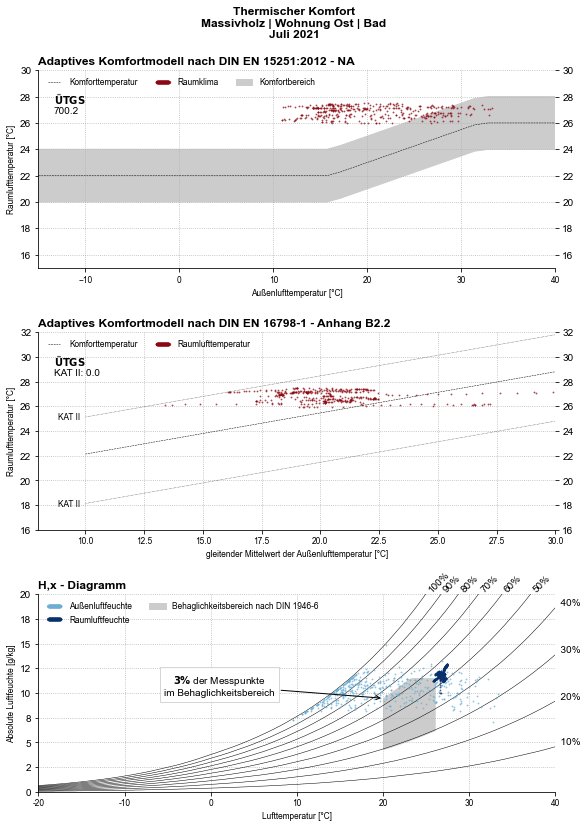

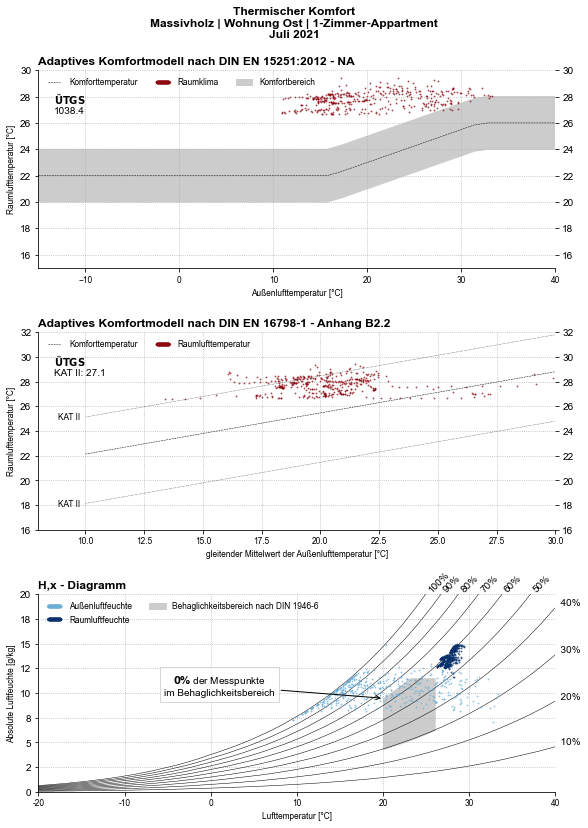

In [37]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    for date, ind in IND[bui].groupby(by=[IND[bui].index.month, IND[bui].index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        else:
            amb = AMB[AMB.index.month == date.month]
            for a, app in enumerate(_wohnungen):
                path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'byMonth')
                if not os.path.exists(path): os.makedirs(path)
                try:
                    with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_{date:%y%m}.pdf'))) as comf_air_pdf:
                                for room in _rooms:
                                    if room in ind[app].columns.get_level_values(level=0).unique():
                                        if not ex:
                                                print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%B %Y")} ---'+100*' ', flush=True, end='\r')
                                        if room != 'F':
                                            print(f'--- plotting (air comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%B %Y")} ---', flush=True, end='\r')
                                            tamb = amb['T_amb'].resample('H').last()
                                            tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                            rhamb = amb['Rh_amb'].resample('H').last()

                                            test = ind[app][room].filter(like='trh_Tair (°C)')
                                            if len(test.columns) == 1:
                                                troom = test.resample('H').last().dropna()
                                            elif len(test.columns) == 2:
                                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                                test.drop(test.columns[1],axis=1,inplace=True)
                                                troom = test.resample('H').last().dropna()
                                            else:
                                                print(f'{bui}-{app}-{room} | Temperatursensor konnte nicht zugeordnet werden.')
                                                troom = None

                                            test = ind[app][room].filter(like='trh_RH (%)')
                                            if len(test.columns) == 1:
                                                rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                       
                                            elif len(test.columns) == 2:
                                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                                test.drop(test.columns[1],axis=1,inplace=True)
                                                rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                                            else:
                                                print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                                rhroom = None

                                            if (isinstance(troom, pd.DataFrame) and len(troom.index) > 0) and (isinstance(rhroom, pd.DataFrame) and len(rhroom.index) > 0):
                                                fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                                fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                                #----#7.1: Thermal Comfort 1 ----
                                                if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                                    thermal_comfort_1(
                                                        TAMB = tamb,
                                                        TROOM = troom,
                                                        ax = ax1,
                                                        mode = 'air',
                                                        legend_ms=3
                                                        )  

                                                #----#7.2: Thermal Comfort 2 ----
                                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                                    thermal_comfort_2(
                                                        TAMBG24 = tamb_g24,
                                                        TROOM = troom,
                                                        ax=ax2,
                                                        kat = ['II'],
                                                        mode = 'air',
                                                        legend_ms=3
                                                        )

                                                #----#7.3: H,x - Diagramm ----
                                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                                    comfort_hx_diagramm(
                                                        t1 = troom,
                                                        rh1 = rhroom,
                                                        rh2 = rhamb,
                                                        t2 = tamb,
                                                        ax = ax3,
                                                        legend_ms=3
                                                        )
                                                fig.tight_layout()
                                                comf_air_pdf.savefig(fig)
                                                if ex: plt.clf()              
                except PermissionError:
                    raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_{date:%y%m}.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
            if not ex: break
print('Done!'+100*' ')

### **Lufttemperatur (jährlich)**
____

Done!                                                                                                                                                                     


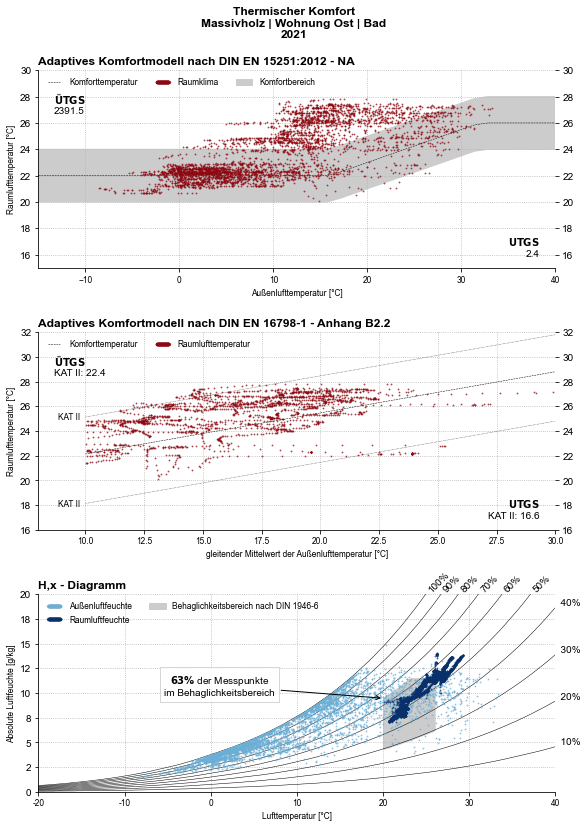

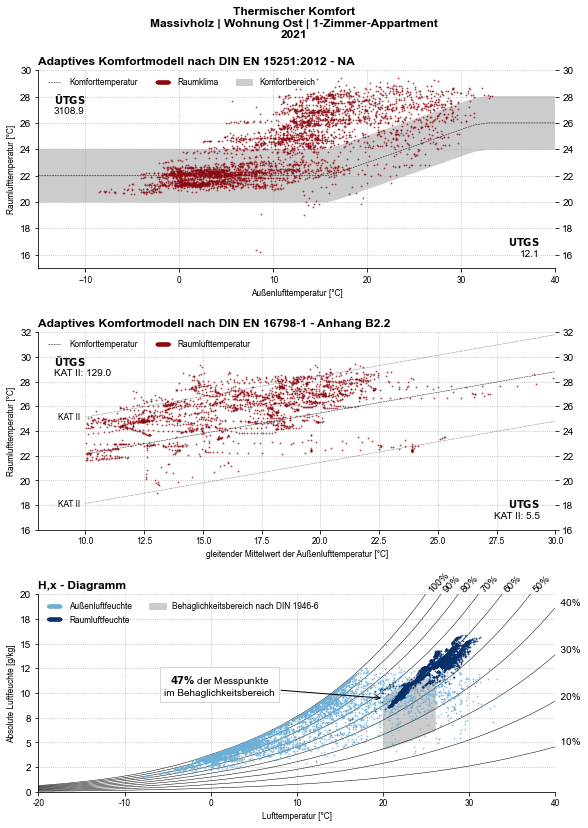

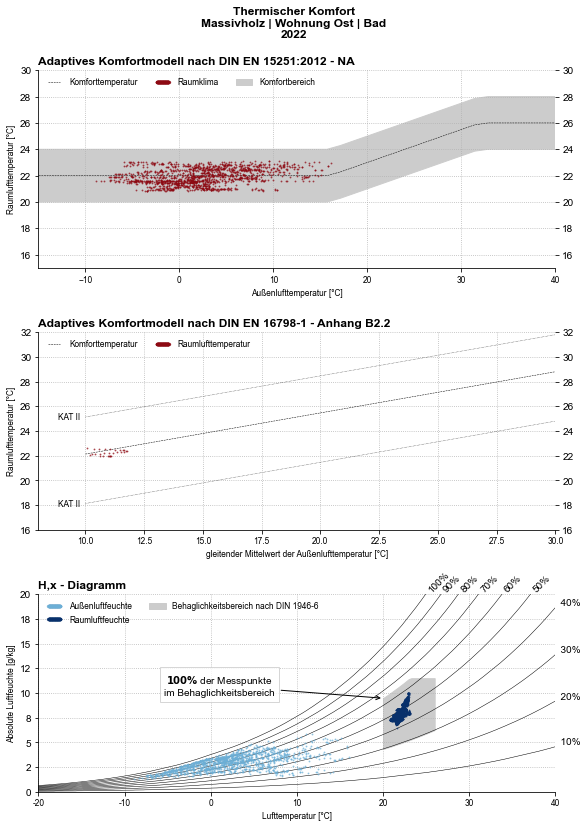

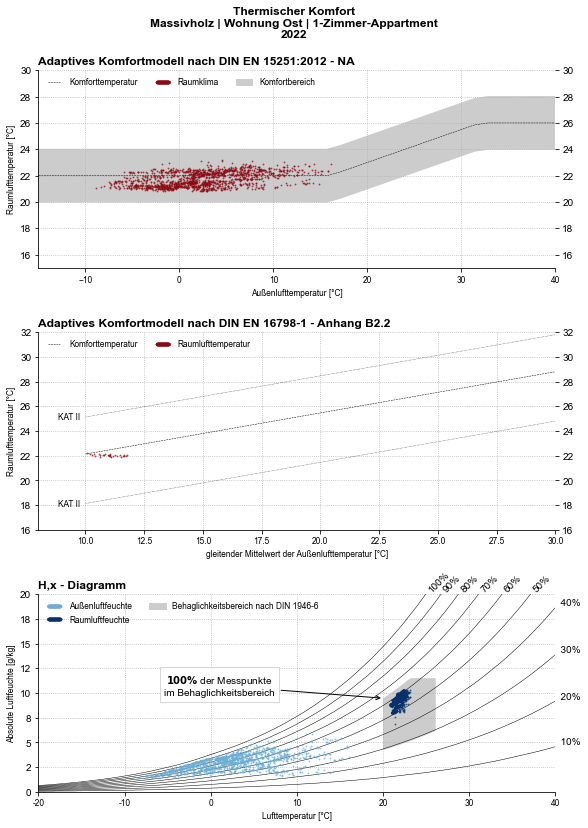

In [36]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    for date, ind in IND[bui].groupby(by=IND[bui].index.year):
        date = dt.date(date, 1, 1)
        amb = AMB[AMB.index.year == date.year]
        for a, app in enumerate(_wohnungen):
            path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'byYear')
            if not os.path.exists(path): os.makedirs(path)
            try:
                with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_{date:%Y}.pdf'))) as comf_air_pdf:
                            for room in _rooms:
                                if room in ind[app].columns.get_level_values(level=0).unique():
                                    if not ex:
                                            print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%Y")} ---'+100*' ', flush=True, end='\r')
                                    if room != 'F':
                                        print(f'--- plotting (air comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%Y")} ---', flush=True, end='\r')
                                        tamb = amb['T_amb'].resample('H').last()
                                        tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                        rhamb = amb['Rh_amb'].resample('H').last()

                                        test = ind[app][room].filter(like='trh_Tair (°C)')
                                        if len(test.columns) == 1:
                                            troom = test.resample('H').last().dropna()
                                        elif len(test.columns) == 2:
                                            test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                            test.drop(test.columns[1],axis=1,inplace=True)
                                            troom = test.resample('H').last().dropna()
                                        else:
                                            print(f'{bui}-{app}-{room} | Temperatursensor konnte nicht zugeordnet werden.')
                                            troom = None

                                        test = ind[app][room].filter(like='trh_RH (%)')
                                        if len(test.columns) == 1:
                                            rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                       
                                        elif len(test.columns) == 2:
                                            test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                            test.drop(test.columns[1],axis=1,inplace=True)
                                            rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                                        else:
                                            print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                            rhroom = None

                                        if (isinstance(troom, pd.DataFrame) and len(troom.index) > 0) and (isinstance(rhroom, pd.DataFrame) and len(rhroom.index) > 0):
                                            fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                            fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%Y")}\n', fontweight = 'bold')
                                            #----#7.1: Thermal Comfort 1 ----
                                            if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                                thermal_comfort_1(
                                                    TAMB = tamb,
                                                    TROOM = troom,
                                                    ax = ax1,
                                                    mode = 'air',
                                                    legend_ms=3
                                                    )  

                                            #----#7.2: Thermal Comfort 2 ----
                                            if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                                thermal_comfort_2(
                                                    TAMBG24 = tamb_g24,
                                                    TROOM = troom,
                                                    ax=ax2,
                                                    kat = ['II'],
                                                    mode = 'air',
                                                    legend_ms=3
                                                    )

                                            #----#7.3: H,x - Diagramm ----
                                            if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                                comfort_hx_diagramm(
                                                    t1 = troom,
                                                    rh1 = rhroom,
                                                    rh2 = rhamb,
                                                    t2 = tamb,
                                                    ax = ax3,
                                                    legend_ms=3
                                                    )
                                            fig.tight_layout()
                                            comf_air_pdf.savefig(fig)
                                            if ex: plt.clf()              
            except PermissionError:
                raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_{date:%Y}.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
            if not ex: break
print('Done!'+100*' ')

### **Lufttemperatur (gesamt)**
____

Done!                                                                                                                                                                       


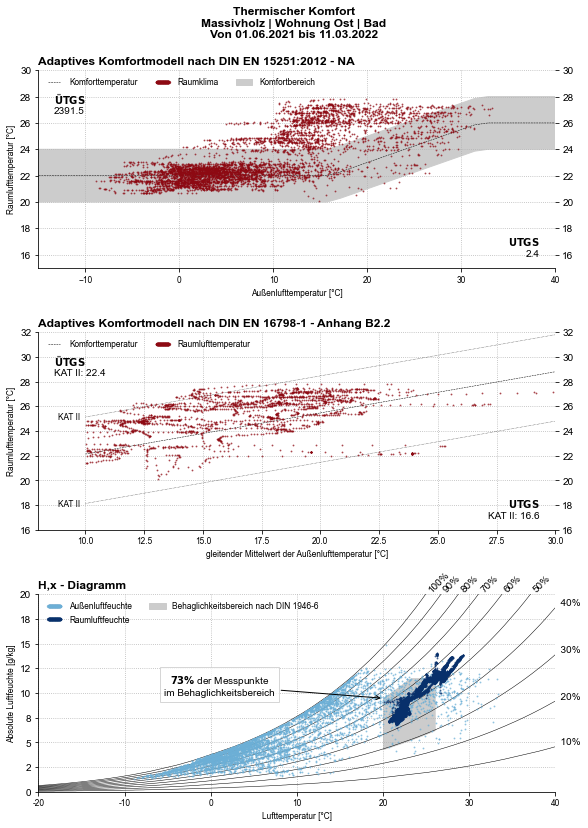

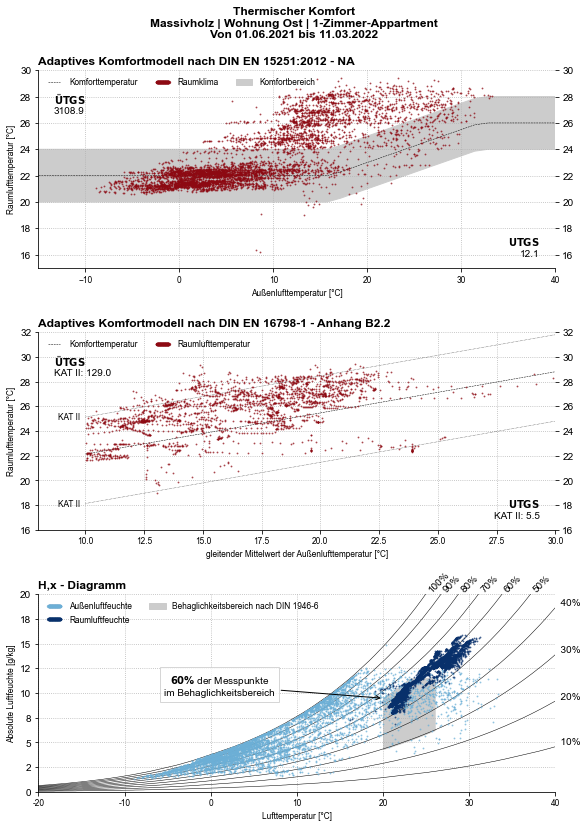

In [38]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    ind = IND[bui]
    amb = AMB
    for a, app in enumerate(_wohnungen):
        path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'Total')
        if not os.path.exists(path): os.makedirs(path)
        try:
            with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_gesamt.pdf'))) as comf_air_pdf:
                        for room in _rooms:
                            if room in ind[app].columns.get_level_values(level=0).unique():
                                if not ex:
                                        print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | gesamt ---'+100*' ', flush=True, end='\r')
                                if room != 'F':
                                    print(f'--- plotting (air comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | gesamt ---', flush=True, end='\r')
                                    tamb = amb['T_amb'].resample('H').last()
                                    tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                    rhamb = amb['Rh_amb'].resample('H').last()

                                    test = ind[app][room].filter(like='trh_Tair (°C)')
                                    if len(test.columns) == 1:
                                        troom = test.resample('H').last().dropna()
                                    elif len(test.columns) == 2:
                                        test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                        test.drop(test.columns[1],axis=1,inplace=True)
                                        troom = test.resample('H').last().dropna()
                                    else:
                                        print(f'{bui}-{app}-{room} | Temperatursensor konnte nicht zugeordnet werden.')
                                        troom = None

                                    test = ind[app][room].filter(like='trh_RH (%)')
                                    if len(test.columns) == 1:
                                        rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                       
                                    elif len(test.columns) == 2:
                                        test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                        test.drop(test.columns[1],axis=1,inplace=True)
                                        rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                                    else:
                                        print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                        rhroom = None

                                    if (isinstance(troom, pd.DataFrame) and len(troom.index) > 0) and (isinstance(rhroom, pd.DataFrame) and len(rhroom.index) > 0):
                                        fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                        fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\nVon {ind.index.min().strftime("%d.%m.%Y")} bis {ind.index.max().strftime("%d.%m.%Y")}\n', fontweight = 'bold')
                                        #----#7.1: Thermal Comfort 1 ----
                                        if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                            thermal_comfort_1(
                                                TAMB = tamb,
                                                TROOM = troom,
                                                ax = ax1,
                                                mode = 'air',
                                                legend_ms=3
                                                )  

                                        #----#7.2: Thermal Comfort 2 ----
                                        if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                            thermal_comfort_2(
                                                TAMBG24 = tamb_g24,
                                                TROOM = troom,
                                                ax=ax2,
                                                kat = ['II'],
                                                mode = 'air',
                                                legend_ms=3
                                                )

                                        #----#7.3: H,x - Diagramm ----
                                        if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                            comfort_hx_diagramm(
                                                t1 = troom,
                                                rh1 = rhroom,
                                                rh2 = rhamb,
                                                t2 = tamb,
                                                ax = ax3,
                                                legend_ms=3
                                                )
                                        fig.tight_layout()
                                        comf_air_pdf.savefig(fig)
                                        if ex: plt.clf()              
        except PermissionError:
            raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_air_gesamt.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
            if not ex: break
print('Done!'+100*' ')

### **operative Temperatur (monatlich)**
____

Done!                                                                                                                                                                          


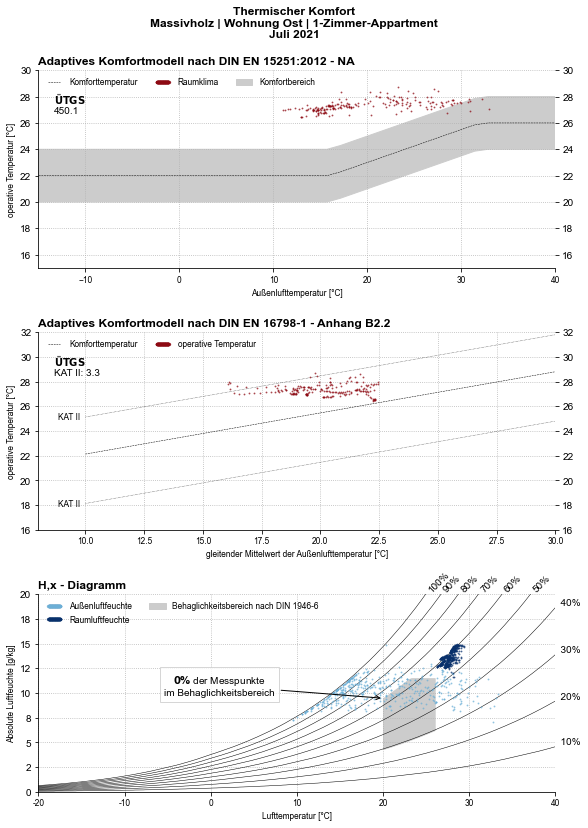

In [39]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    for date, ind in IND[bui].groupby(by=[IND[bui].index.month, IND[bui].index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        else:
            amb = AMB[AMB.index.month == date.month]
            for a, app in enumerate(_wohnungen):
                path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'byMonth')
                if not os.path.exists(path): os.makedirs(path)
                try:
                    with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_{date:%y%m}.pdf'))) as comf_op_pdf:
                        for room in _rooms:
                            if room in ind[app].columns.get_level_values(level=0).unique():
                                if not ex:
                                        print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%B %Y")} ---'+100*' ', flush=True, end='\r')
                                ### Comfort PDF
                                if room == 'SZ' or room == 'WZ' or room == 'SWK':
                                    print(f'--- plotting (operative comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%B %Y")} ---', flush=True, end='\r')
                                    tamb = amb['T_amb'].resample('H').last()
                                    tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                    rhamb = amb['Rh_amb'].resample('H').last()

                                    test = ind[app][room].filter(like='trh_Tair (°C)')
                                    if len(test.columns) == 1:
                                        troom = test.resample('H').last().dropna()
                                    elif len(test.columns) == 2:
                                        test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                        test.drop(test.columns[1],axis=1,inplace=True)
                                        troom = test.resample('H').last().dropna()
                                        if len(troom) == 0 : troom = None
                                    else:
                                        print(f'{bui}-{app}-{room} | Lufttemperatur konnte nicht zugeordnet werden.')
                                        troom = None

                                    test = ind[app][room].filter(like='pt_Tsk (°C)')
                                    if len(test.columns) == 1:
                                        tsk = test.resample('H').last().dropna()
                                    elif len(test.columns) == 2:
                                        test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                        test.drop(test.columns[1],axis=1,inplace=True)
                                        tsk = test.resample('H').last().dropna()
                                        if len(tsk) == 0 : tsk = None
                                    else:
                                        print(f'{bui}-{app}-{room} | Schwarzkugelthermometer konnte nicht zugeordnet werden.')
                                        tsk = None

                                    if isinstance(tsk, (pd.Series, pd.DataFrame)) and isinstance(troom,(pd.Series, pd.DataFrame)):
                                        top = calcTOP(troom,tsk).dropna()
                                    elif not isinstance(tsk, (pd.Series, pd.DataFrame)):
                                        print('tsk')
                                    elif not isinstance(troom, (pd.Series, pd.DataFrame)):
                                        print('troom')


                                    test = ind[app][room].filter(like='trh_RH (%)')
                                    if len(test.columns) == 1:
                                        rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                          
                                    elif len(test.columns) == 2:
                                        test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                        test.drop(test.columns[1],axis=1,inplace=True)
                                        rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                                    else:
                                        print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                        rhroom = None

                                    if (isinstance(top, (pd.Series, pd.DataFrame)) and len(top.index) > 0) and (isinstance(rhroom, (pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                        fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                        fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
                                        #----#7.1: Thermal Comfort 1 ----
                                        if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                            thermal_comfort_1(
                                                TAMB = tamb,
                                                TROOM = top,
                                                ax = ax1,
                                                mode = 'op',
                                                legend_ms=3
                                                )  

                                        #----#7.2: Thermal Comfort 2 ----
                                        if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                            thermal_comfort_2(
                                                TAMBG24 = tamb_g24,
                                                TROOM = top,
                                                ax=ax2,
                                                kat = ['II'],
                                                mode = 'op',
                                                legend_ms=3
                                                )

                                        #----#7.3: H,x - Diagramm ----
                                        if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                            comfort_hx_diagramm(
                                                t1 = troom,
                                                rh1 = rhroom,
                                                rh2 = rhamb,
                                                t2 = tamb,
                                                ax = ax3,
                                                legend_ms=3
                                                )
                                        fig.tight_layout()
                                        comf_op_pdf.savefig(fig)
                                        if ex: plt.clf()
                except PermissionError:
                    raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_{date:%y%m}.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
            if not ex: break
print('Done!'+100*' ')

### **operative Temperatur (jährlich)**
____

Done!                                                                                                                                                                     


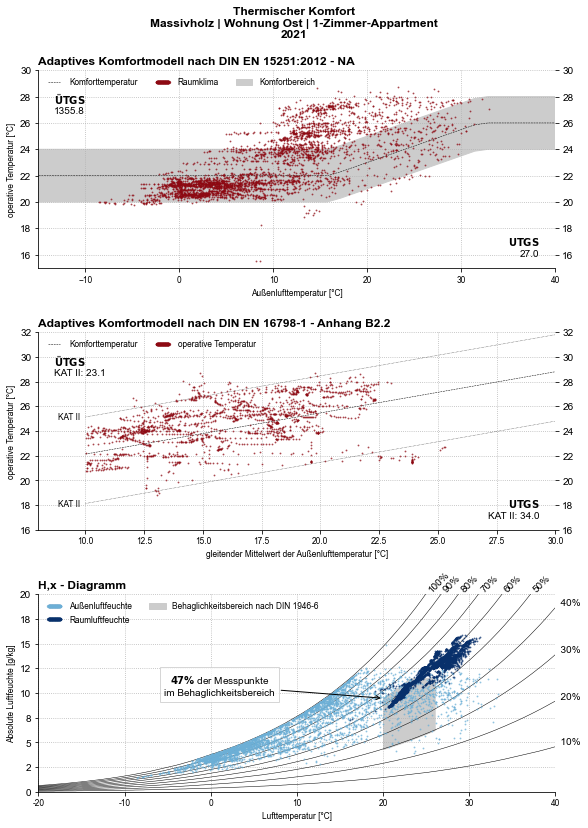

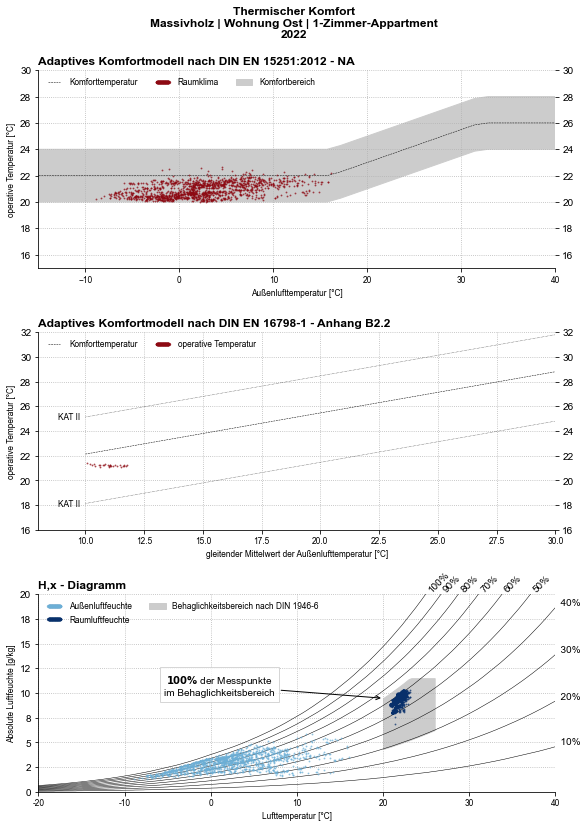

In [44]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    for date, ind in IND[bui].groupby(by=IND[bui].index.year):
        date = dt.date(date, 1, 1)
        amb = AMB[AMB.index.year == date.year]
        for a, app in enumerate(_wohnungen):
            path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'byYear')
            if not os.path.exists(path): os.makedirs(path)
            try:
                with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_{date:%Y}.pdf'))) as comf_op_pdf:
                    for room in _rooms:
                        if room in ind[app].columns.get_level_values(level=0).unique():
                            if not ex:
                                    print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%Y")} ---'+100*' ', flush=True, end='\r')
                            ### Comfort PDF
                            if room == 'SZ' or room == 'WZ' or room == 'SWK':
                                print(f'--- plotting (operative comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | {date.strftime("%Y")} ---', flush=True, end='\r')
                                tamb = amb['T_amb'].resample('H').last()
                                tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                                rhamb = amb['Rh_amb'].resample('H').last()

                                test = ind[app][room].filter(like='trh_Tair (°C)')
                                if len(test.columns) == 1:
                                    troom = test.resample('H').last().dropna()
                                elif len(test.columns) == 2:
                                    test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                    test.drop(test.columns[1],axis=1,inplace=True)
                                    troom = test.resample('H').last().dropna()
                                    if len(troom) == 0 : troom = None
                                else:
                                    print(f'{bui}-{app}-{room} | Lufttemperatur konnte nicht zugeordnet werden.')
                                    troom = None

                                test = ind[app][room].filter(like='pt_Tsk (°C)')
                                if len(test.columns) == 1:
                                    tsk = test.resample('H').last().dropna()
                                elif len(test.columns) == 2:
                                    test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                    test.drop(test.columns[1],axis=1,inplace=True)
                                    tsk = test.resample('H').last().dropna()
                                    if len(tsk) == 0 : tsk = None
                                else:
                                    print(f'{bui}-{app}-{room} | Schwarzkugelthermometer konnte nicht zugeordnet werden.')
                                    tsk = None

                                if isinstance(tsk, (pd.Series, pd.DataFrame)) and isinstance(troom,(pd.Series, pd.DataFrame)):
                                    top = calcTOP(troom,tsk).dropna()
                                elif not isinstance(tsk, (pd.Series, pd.DataFrame)):
                                    print('tsk')
                                elif not isinstance(troom, (pd.Series, pd.DataFrame)):
                                    print('troom')


                                test = ind[app][room].filter(like='trh_RH (%)')
                                if len(test.columns) == 1:
                                    rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                          
                                elif len(test.columns) == 2:
                                    test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                    test.drop(test.columns[1],axis=1,inplace=True)
                                    rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                                else:
                                    print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                    rhroom = None

                                if (isinstance(top, (pd.Series, pd.DataFrame)) and len(top.index) > 0) and (isinstance(rhroom, (pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                    fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                    fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\n{date.strftime("%Y")}\n', fontweight = 'bold')
                                    #----#7.1: Thermal Comfort 1 ----
                                    if (isinstance(top,(pd.Series, pd.DataFrame)) and len(top.index) > 0) and (isinstance(tamb,(pd.Series, pd.DataFrame)) and len(tamb.index) > 0):
                                        thermal_comfort_1(
                                            TAMB = tamb,
                                            TROOM = top,
                                            ax = ax1,
                                            mode = 'op',
                                            legend_ms=3
                                            )  

                                    #----#7.2: Thermal Comfort 2 ----
                                    if (isinstance(top,(pd.Series, pd.DataFrame)) and len(top.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                        thermal_comfort_2(
                                            TAMBG24 = tamb_g24,
                                            TROOM = top,
                                            ax=ax2,
                                            kat = ['II'],
                                            mode = 'op',
                                            legend_ms=3
                                            )

                                    #----#7.3: H,x - Diagramm ----
                                    if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                        comfort_hx_diagramm(
                                            t1 = troom,
                                            rh1 = rhroom,
                                            rh2 = rhamb,
                                            t2 = tamb,
                                            ax = ax3,
                                            legend_ms=3
                                            )
                                    fig.tight_layout()
                                    comf_op_pdf.savefig(fig)
                                    if ex: plt.clf()
            except PermissionError:
                raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_{date:%Y}.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
    if not ex: break
print('Done!'+100*' ')

### **operative Temperatur (gesamt)**
____

Done!                                                                                                                                                                       


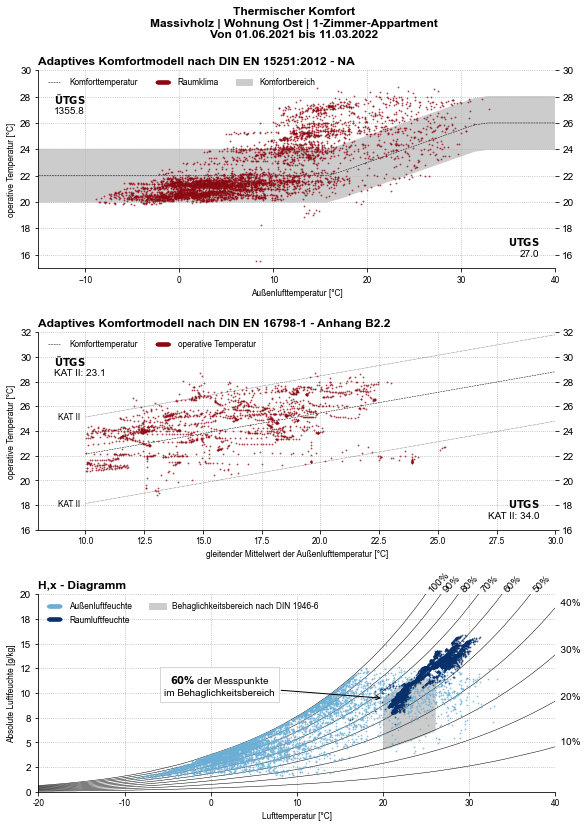

In [40]:
for b, bui in enumerate(_BUID):
    if ex: print(f'--- plotting {BUID[bui]} ---'+100*' ')
    ind = IND[bui]
    amb = AMB
    for a, app in enumerate(_wohnungen):
        path = os.path.join(dir_results,'Thermischer Comfort',BUID[bui],WOHNUNGEN[app],'Total')
        if not os.path.exists(path): os.makedirs(path)
        try:
            with PdfPages(os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_gesamt.pdf'))) as comf_op_pdf:
                for room in _rooms:
                    if room in ind[app].columns.get_level_values(level=0).unique():
                        if not ex:
                                print(f'--- plotting {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | gesamt ---'+100*' ', flush=True, end='\r')
                        ### Comfort PDF
                        if room == 'SZ' or room == 'WZ' or room == 'SWK':
                            print(f'--- plotting (operative comfort) {BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]} | gesamt ---', flush=True, end='\r')
                            tamb = amb['T_amb'].resample('H').last()
                            tamb_g24 = tamb.rolling('24h').mean().resample('H').last()
                            rhamb = amb['Rh_amb'].resample('H').last()

                            test = ind[app][room].filter(like='trh_Tair (°C)')
                            if len(test.columns) == 1:
                                troom = test.resample('H').last().dropna()
                            elif len(test.columns) == 2:
                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                test.drop(test.columns[1],axis=1,inplace=True)
                                troom = test.resample('H').last().dropna()
                                if len(troom) == 0 : troom = None
                            else:
                                print(f'{bui}-{app}-{room} | Lufttemperatur konnte nicht zugeordnet werden.')
                                troom = None

                            test = ind[app][room].filter(like='pt_Tsk (°C)')
                            if len(test.columns) == 1:
                                tsk = test.resample('H').last().dropna()
                            elif len(test.columns) == 2:
                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                test.drop(test.columns[1],axis=1,inplace=True)
                                tsk = test.resample('H').last().dropna()
                                if len(tsk) == 0 : tsk = None
                            else:
                                print(f'{bui}-{app}-{room} | Schwarzkugelthermometer konnte nicht zugeordnet werden.')
                                tsk = None

                            if isinstance(tsk, (pd.Series, pd.DataFrame)) and isinstance(troom,(pd.Series, pd.DataFrame)):
                                top = calcTOP(troom,tsk).dropna()
                            elif not isinstance(tsk, (pd.Series, pd.DataFrame)):
                                print('tsk')
                            elif not isinstance(troom, (pd.Series, pd.DataFrame)):
                                print('troom')


                            test = ind[app][room].filter(like='trh_RH (%)')
                            if len(test.columns) == 1:
                                rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]                                          
                            elif len(test.columns) == 2:
                                test.iloc[:,0].fillna(test.iloc[:,1],inplace=True)
                                test.drop(test.columns[1],axis=1,inplace=True)
                                rhroom = test.resample('H').last().dropna() - KORREKTUR_RH[bui]    
                            else:
                                print(f'{bui}-{app}-{room} | Luftfeuchte konnte nicht zugeordnet werden.')
                                rhroom = None

                            if (isinstance(top, (pd.Series, pd.DataFrame)) and len(top.index) > 0) and (isinstance(rhroom, (pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                fig, (ax1 ,ax2, ax3) = plt.subplots(3,1, figsize = din_a4)
                                fig.suptitle(f'Thermischer Komfort\n{BUID[bui]} | Wohnung {WOHNUNGEN[app]} | {ROOMS[room]}\nVon {ind.index.min().strftime("%d.%m.%Y")} bis {ind.index.max().strftime("%d.%m.%Y")}\n', fontweight = 'bold')
                                #----#7.1: Thermal Comfort 1 ----
                                if isinstance(troom,(pd.Series, pd.DataFrame)) and isinstance(tamb,(pd.Series, pd.DataFrame)):
                                    thermal_comfort_1(
                                        TAMB = tamb,
                                        TROOM = top,
                                        ax = ax1,
                                        mode = 'op',
                                        legend_ms=3
                                        )  

                                #----#7.2: Thermal Comfort 2 ----
                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(tamb_g24,(pd.Series, pd.DataFrame)) and len(tamb_g24.index) > 0):
                                    thermal_comfort_2(
                                        TAMBG24 = tamb_g24,
                                        TROOM = top,
                                        ax=ax2,
                                        kat = ['II'],
                                        mode = 'op',
                                        legend_ms=3
                                        )

                                #----#7.3: H,x - Diagramm ----
                                if (isinstance(troom,(pd.Series, pd.DataFrame)) and len(troom.index) > 0) and (isinstance(rhroom,(pd.Series, pd.DataFrame)) and len(rhroom.index) > 0):
                                    comfort_hx_diagramm(
                                        t1 = troom,
                                        rh1 = rhroom,
                                        rh2 = rhamb,
                                        t2 = tamb,
                                        ax = ax3,
                                        legend_ms=3
                                        )
                                fig.tight_layout()
                                comf_op_pdf.savefig(fig)
                                if ex: plt.clf()
        except PermissionError:
            raise Warning(f"Datei {os.path.join(os.path.join(path,f'{bui}_{app}_Thermischer_Comfort_operative_gesamt.pdf'))} konnte nicht geöffnet werden und wurde übersprungen. Vielleicht ist die Datei gerade geöffnet?")
    if not ex: break
print('Done!'+100*' ')